<a href="https://colab.research.google.com/github/LuqLu/ml-proj/blob/main/fec_cnn_from_scratch_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description

The notebook describes the `building`, `training`, and `evaluation` of a deep learning model for image classification using the Kaggle dataset.

The task of the model is facial emotion recognition. We will utilize two models for this task: the first model will be built `from scratch`, while for the second model, we will employ `transfer learning` and `fine-tuning` techniques. With transfer learning, we leverage a pre-trained model and adapt it to our specific task by training only the final layers on our dataset. This approach enables the model to recognize features specific to our dataset while benefiting from the knowledge learned from the original training.

The data set is divided into a training set (about `20000` images), a validation set (about `8500` images) and a test set (about `7000` images). Each image belongs to one of 7 classes `[angry, disgust, fear, happy, neutral, sad, surprise]`.

Since the classes are not represented equally we are dealing with `unbalanced data`. Therefore, to accurately assess the model's performance, in addition to the `accuracy` metric, we will also use the `precision` and `recall` metrics.



## Instalation of required packages

The `opendatasets` package provides functionality to download datasets from online sources, such as Kaggle, using an API.

In [1]:
!pip install opendatasets

## Import of necessary Python libraries and modules

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import glob as glob
import opendatasets as od

from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

## Downloading the data set from the Kaggle website
We will use the dataset from the Kaggle website.

In [3]:
od.download(
    "https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: luee7luee
Your Kaggle Key: ··········


100%|██████████| 121M/121M [00:01<00:00, 93.8MB/s]


## Data preparation

The downloaded data set contains two directories: `train` and `validation`. From the train set we will extract the validation set, and the original validation set will serve as the test set, therefore we rename the validation directory to `test`.

In [4]:
os.rename('/content/face-expression-recognition-dataset/images/validation', \
          '/content/face-expression-recognition-dataset/images/test')

Setting the same `seed` value so that the experimental results are consistent across runs.

In [5]:
SEED_VALUE = 10
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

Defining configuration parameters for the data set and for training

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
  NUM_CLASSES: int = 7 # Number of classes in the dataset
  IMG_HEIGHT: int = 48 # Height of input images
  IMG_WIDTH: int = 48 # Width of input images
  FINE_TUNE_IMG_HEIGHT: int = 224 # Height of input images for transfer learning process
  FINE_TUNE_IMG_WIDTH: int = 224 # Width of input images for transfer learning process
  CHANNELS: int = 3 # Number of channels in input images
  TRAIN_DATA_PATH: str = './face-expression-recognition-dataset/images/train'
  TEST_DATA_PATH: str = './face-expression-recognition-dataset/images/test'

@dataclass(frozen=True)
class TrainingConfig:
  BATCH_SIZE: int = 32 # Batch size for training
  EPOCHS: int = 50
  FINE_TUNE_EPOCHS: int = 10
  LEARNING_RATE: float = 0.01
  FINE_TUNE_LEARNING_RATE: float = 0.0001
  DROPOUT: float = 0.6
  LAYERS_FINE_TUNE: int = 4 # Number of layers to fine-tune

Creation of training, validation and test datasets from image directories.

We use `image_dataset_from_directory` function which is a function provided by TensorFlow's Keras API specifically designed for loading image datasets from a directory structure. It reads images from a directory structure where each subdirectory represents a class or category, and the images belonging to that class are stored within that subdirectory.

In [7]:
train_dataset, valid_dataset = image_dataset_from_directory(directory=DatasetConfig.TRAIN_DATA_PATH,
                                                            batch_size=TrainingConfig.BATCH_SIZE,
                                                            shuffle=True,
                                                            seed=SEED_VALUE,
                                                            label_mode='int',
                                                            image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                                            validation_split=0.3,
                                                            subset = 'both'
                                                          )

test_dataset = image_dataset_from_directory(directory=DatasetConfig.TEST_DATA_PATH,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 28821 files belonging to 7 classes.
Using 20175 files for training.
Using 8646 files for validation.
Found 7066 files belonging to 7 classes.


Checking data categories

In [8]:
test_dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Preparing a function to display the number of labels

In [9]:
def plot_label_distribution(dataset):
  """
  Plot the distribution of labels in the dataset.

  Args:
    dataset: Dataset containing batches of (images, labels).
  """
  labels = [label.numpy() for _, label in dataset.unbatch()]

  # Count the occurrences of each label
  label_counts = pd.Series(labels).value_counts().sort_index()

  # Using class names as index labels
  descriptive_index = dataset.class_names
  label_counts.index = descriptive_index

  label_counts.plot(kind='bar')

Plot the distribution of labels in the datasets

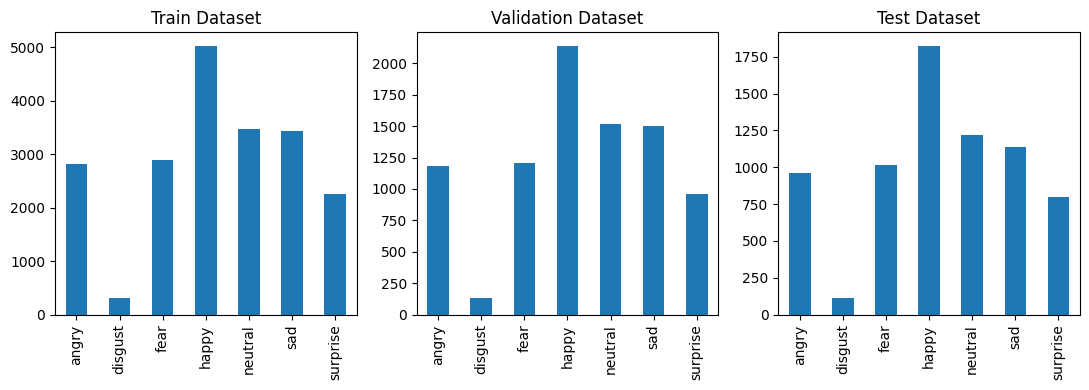

In [10]:
# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

# Set titles and plot on each subplot
plt.sca(axs[0])
plot_label_distribution(train_dataset)
plt.title('Train Dataset')

plt.sca(axs[1])
plot_label_distribution(valid_dataset)
plt.title('Validation Dataset')

plt.sca(axs[2])
plot_label_distribution(test_dataset)
plt.title('Test Dataset')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Preparing a function to plot images with their associated ground truth labels

In [8]:
def plot_images_with_labels(dataset, class_names):
  """
  Plot images with their associated ground truth labels from a dataset.

  Args:
    dataset: Dataset containing batches of images and labels.
    class_names: List of class names for labeling the plot.
  """
  num_rows = 4
  num_cols = 5
  plt.figure(figsize=(10, 10))

  # Assumes dataset batch_size is at least 32 (TrainingConfig.BATCH_SIZE).
  for image_batch, labels_batch in dataset.take(1):
    # Plot images from the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
      ax = plt.subplot(num_rows, num_cols, i + 1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      truth_idx = labels_batch[i].numpy()
      plt.title(class_names[truth_idx])
      plt.axis("on")

  plt.show()

Displaying sample images from Training Dataset

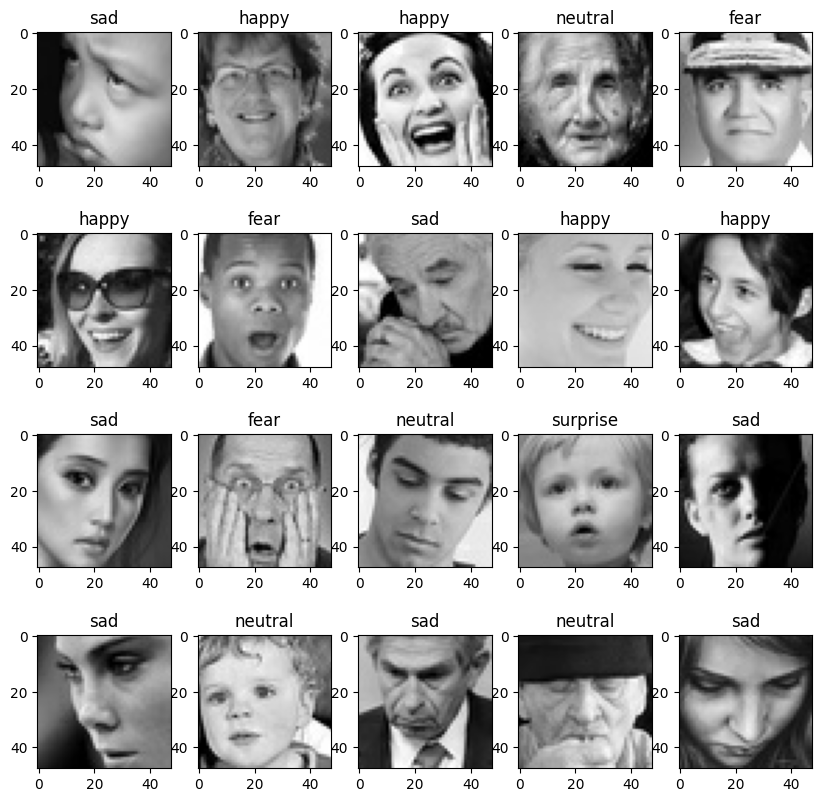

In [36]:
class_names = train_dataset.class_names
plot_images_with_labels(train_dataset, class_names)

## Building the model

Defining a function that creates a model.

Function `cnn_model` creates a `Convolutional Neural Network (CNN)` model for image classification tasks. This model architecture follows a typical pattern for CNNs, consisting of alternating convolutional and pooling layers followed by fully connected layers for classification.


### **Model Architecture:**

**Parameters**
- input_shape - tuple representing the shape of the input data (`height`, `width`, `channels`).
- dropout_rate - dropout rate used in the `Dropout` layers for regularization.

**Input Layer**
- Shape: (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
- This specifies the dimensions of the input images.

**Convolutional Blocks**
- Three convolutional blocks are defined.
- Each block consists of two consecutive Convolutional layers (`Conv2D`), followed by `Batch Normalization`, Max Pooling (`MaxPooling2D`), and `Dropout` layers for regularization.
- The number of filters increases from 64 to 128 to 256 progressively in the convolutional blocks.

**Convolutional Layers**

Each convolutional layer has:
- filters - number of filters/kernels
- kernel_size - size of the convolutional kernel
- padding - type of padding used (`same` padding maintains the input size)
- activation - activation function (`elu` is used here)
- kernel_initializer - method for initializing the weights of the neural network layers' kernels (`he_normal` in this case)

**Batch Normalization**

- `Batch Normalization` layers are added after each convolutional layer to normalize the activations of the previous layer.

**Pooling**

- `Max Pooling` layers with a pool size of (3, 3) and (2, 2) are used after each convolutional block to reduce spatial dimensions.

**Regularization**

- `Dropout` layers are included after each convolutional block and after the fully connected layer for regularization to prevent overfitting.

**Flattening Layer**
- Flattens the convolutional features into a vector.

**Fully Connected Layers**
- Two fully connected (`Dense`) layers are added with `elu` activation.
- The first Dense layer has 128 units.

**Output Layer**
- Dense layer with 7 units (because it's a classification task with 7 classes) and `softmax` activation for multi-class classification.



In [13]:
def cnn_model(input_shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS),
              dropout_rate=TrainingConfig.DROPOUT
              ):
  """
  Creates a CNN model.

  Args:
    input_shape: Tuple, shape of the input data (height, width, channels).
    dropout_rate: Dropout rate for regularization.

  Returns:
    Keras Sequential model.
  """
  model = Sequential()

  # Conv Block 1: 64 Filters, MaxPool.
  model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='elu', kernel_initializer='he_normal', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(dropout_rate))

  # Conv Block 2: 128 Filters, MaxPool.
  model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout_rate))

  # Conv Block 3: 256 Filters, MaxPool.
  model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout_rate))

  # Flatten the convolutional features.
  model.add(Flatten())

  # Fully connected block
  model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(Dense(7, activation='softmax'))

  return model

Create a model and display its parameters

In [ ]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                        

## Model training

Model compilation

Below code uses the `Sparse Categorical Crossentropy` loss function due to the use of integer-encoded labels in the dataset. This loss function is tailored for scenarios where class labels are represented as integers.
For datasets using one-hot encoded labels, the `Categorical Crossentropy` loss function is more suitable.
Since we included a `Softmax` layer in the model output, we specify `from_logits=False` (this is the default setting, but we provide it for clarity).
Alternatively, you can remove the softmax layer in the model and set `from_logits=True`, and the loss function will apply the softmax function internally. The results should be identical.

As an optimizer is used `Adam`, which is a popular optimization algorithm for training deep neural networks.

The `accuracy` metric was used, which is a common metric for classification tasks. It measures the percentage of correctly predicted labels among all samples.

In [ ]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
             )

Start of model training

Callback class `ModelCheckpoint` was used to save only the model weights that result in the best performance on metric `accuracy`.

In [ ]:
checkpoint = ModelCheckpoint(filepath='from_scratch_model.keras', save_best_only=True)
history = model.fit(train_dataset,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_dataset,
                    callbacks = [checkpoint]
                   )

Epoch 1/50
631/631 [==============================] - 28s 29ms/step - loss: 1.9042 - accuracy: 0.2401 - val_loss: 1.8246 - val_accuracy: 0.2628
Epoch 2/50
631/631 [==============================] - 16s 25ms/step - loss: 1.6371 - accuracy: 0.3502 - val_loss: 1.7839 - val_accuracy: 0.3035
Epoch 3/50
631/631 [==============================] - 21s 33ms/step - loss: 1.5058 - accuracy: 0.4126 - val_loss: 1.4374 - val_accuracy: 0.4406
Epoch 4/50
631/631 [==============================] - 21s 33ms/step - loss: 1.4308 - accuracy: 0.4437 - val_loss: 1.3726 - val_accuracy: 0.4690
Epoch 5/50
631/631 [==============================] - 16s 25ms/step - loss: 1.3748 - accuracy: 0.4744 - val_loss: 1.3163 - val_accuracy: 0.4960
Epoch 6/50
631/631 [==============================] - 17s 28ms/step - loss: 1.3455 - accuracy: 0.4859 - val_loss: 1.2565 - val_accuracy: 0.5133
Epoch 7/50
631/631 [==============================] - 17s 27ms/step - loss: 1.3130 - accuracy: 0.5006 - val_loss: 1.2177 - val_accuracy:

## Plot Loss and Accuracy

Define a function that represents on a graph the value of `loss` and `accuracy` of the trained model.

In [10]:
def plot_metric(metrics, title=None, ylabel=None, ylim=None,
                 metric_name=None, color=None, epochs=50
                 ):
  """
  Plot training metrics over epochs.

  Args:
    metrics: List or tuple of metric values to plot.
    title: Title of the plot.
    ylabel: Label for the y-axis.
    ylim: Tuple specifying the y-axis limits (min, max).
    metric_name: List or tuple of names for the metrics.
    color: List or tuple of colors for each metric.
    epochs: Number of epochs for the x-axis.

  Returns:
    None
  """
  fig, ax = plt.subplots(figsize=(14, 4))

  for idx, metric in enumerate(metrics):
      ax.plot(metric, color=color[idx])

  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.xlim([0, epochs-1])
  plt.ylim(ylim)
  ax.xaxis.set_major_locator(MultipleLocator(5))
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  plt.grid(True)
  plt.legend(metric_name)
  plt.show()
  plt.close()

Retrieve training results (`loss` and `accuracy` for train and validation data set) and display them on a chart.

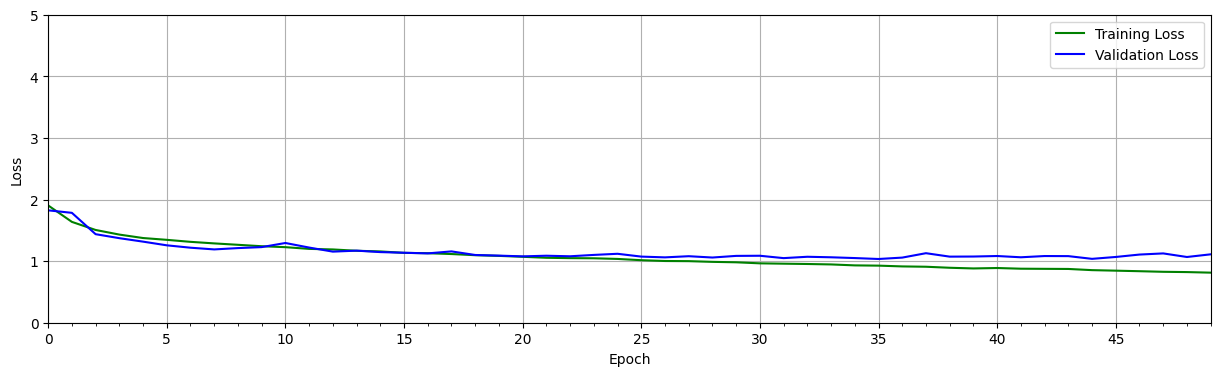

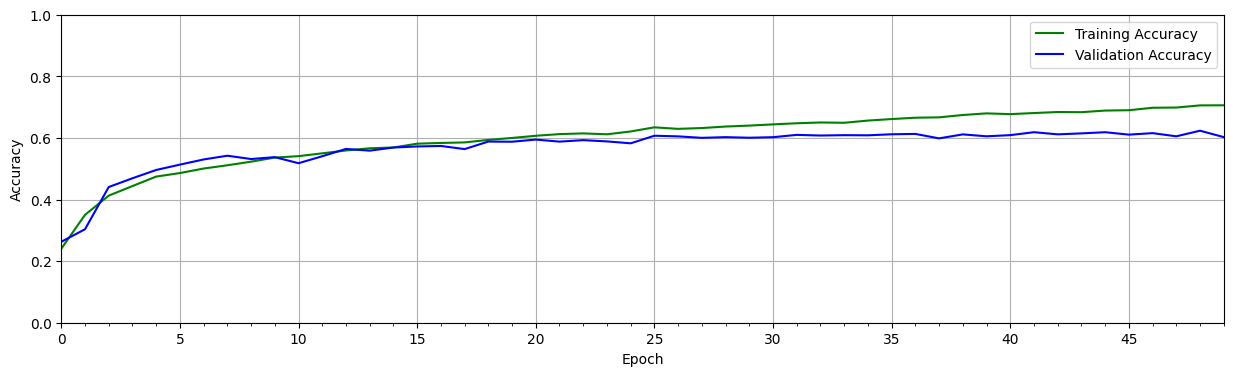

In [ ]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_metric([train_loss, valid_loss],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"],
            epochs=TrainingConfig.EPOCHS);

print('\n')
plot_metric([train_acc, valid_acc],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"]
            epochs=TrainingConfig.EPOCHS)

From the graph, you can observe that starting from around epoch 25, the model begins to `overfit`. While its performance continues to improve on the training set, it no longer shows improvement on the validation set.

## Model evaluation
Verification of model performance on test set

In [11]:
# Load the best weights saved by the ModelCheckpoint callback
best_model = load_model('from_scratch_model.keras')

Loss and Accuracy

In [12]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f'\nTest loss: {test_loss:.3f}')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

221/221 [==============================] - 5s 10ms/step - loss: 1.0089 - accuracy: 0.6353

Test loss: 1.009
Test accuracy: 63.53%


Precision, Recall, F1

To calculate additional metrics (`Precision`, `Recall`, `F1`) we will use the function `classification_report` from the module `sklearn.metrics`.

Before that, we will re-create the test set, deactivating the element shuffling operation (by setting `shuffle=False`), so that when retrieving data from the test set, we will get the same order of elements every time.

In [13]:
test_dataset_no_shuffle = image_dataset_from_directory(directory=DatasetConfig.TEST_DATA_PATH,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 7066 files belonging to 7 classes.


Make predictions and determine predicted labels

In [14]:
predictions = best_model.predict(test_dataset_no_shuffle)
predicted_labels = np.argmax(predictions, axis=1)

221/221 [==============================] - 2s 9ms/step


Determine true labels

In [ ]:
# Flatten true labels from the test dataset
label_values = [label.numpy() for _, label in test_dataset_no_shuffle.unbatch()]
true_labels = np.array(label_values)

Display of metrics

In [15]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       960
           1       0.78      0.42      0.55       111
           2       0.49      0.37      0.42      1018
           3       0.85      0.84      0.85      1825
           4       0.55      0.66      0.60      1216
           5       0.52      0.46      0.49      1139
           6       0.70      0.81      0.75       797

    accuracy                           0.64      7066
   macro avg       0.63      0.59      0.60      7066
weighted avg       0.63      0.64      0.63      7066



The efficiency achieved on the test set (63.53%) is not very high. Let's compare whether the model achieves better performance than if we guessed what class the photo belongs to. To do this, we will generate random predictions and compare them with the true labels.

In [16]:
class_counts = {}

# Iterate over the test_dataset and count class occurrences
for _, labels in test_dataset_no_shuffle:
  for label in labels.numpy():
    if label in class_counts:
      class_counts[label] += 1
    else:
      class_counts[label] = 1

# Define class frequencies
class_frequencies = [value for key, value in sorted(class_counts.items(), key=lambda x: x[0])]

# Calculate class probabilities
total_elements = sum(class_frequencies)
class_probabilities = [freq / total_elements for freq in class_frequencies]

# Generate random predictions
random_predictions = np.random.choice(np.arange(0, 7), size=total_elements, p=class_probabilities)

In [17]:
print(classification_report(true_labels, random_predictions))

              precision    recall  f1-score   support

           0       0.13      0.14      0.14       960
           1       0.00      0.00      0.00       111
           2       0.15      0.16      0.16      1018
           3       0.25      0.25      0.25      1825
           4       0.18      0.18      0.18      1216
           5       0.17      0.16      0.16      1139
           6       0.09      0.08      0.09       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



Although the model does not give satisfactory results, its result is much better than that of a model based on random prediction.

## Confusion matrix for the model

Preparing the function to display Confusion Matrix

In [18]:
def plot_confusion_matrix(dataset, predicted_labels, class_names, is_normalized=False):
  """
  Plot a confusion matrix for the test dataset.

  Args:
      dataset: TensorFlow Dataset object containing image and label pairs.
      predicted_labels: Predicted labels for the test dataset.
      class_names: List of class names corresponding to the label indices.
      is_normalized: Determines if confusion matrix should be normalized or not (True: normalized, False: regular).

  Returns:
      None
  """
  # Flatten the true labels from the dataset
  y_test_integer_labels = []
  test_dataset_labels = [label.numpy() for _, label in dataset]
  for label in test_dataset_labels:
    y_test_integer_labels.extend(label)

  # Generate confusion matrix
  cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)
  fmt = 'd'

  # Convert to float and perform normalization
  if is_normalized:
    cm_float = tf.cast(cm, dtype=tf.float32)
    cm_sum = tf.reduce_sum(cm_float, axis=1, keepdims=True)
    cm = cm_float / cm_sum
    fmt = '.2g'

  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=[10, 5])
  sn.heatmap(cm, annot=True, fmt=fmt, annot_kws={"size": 12}, xticklabels=class_names, yticklabels=class_names, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.show()

Displaying Confusion Matrix

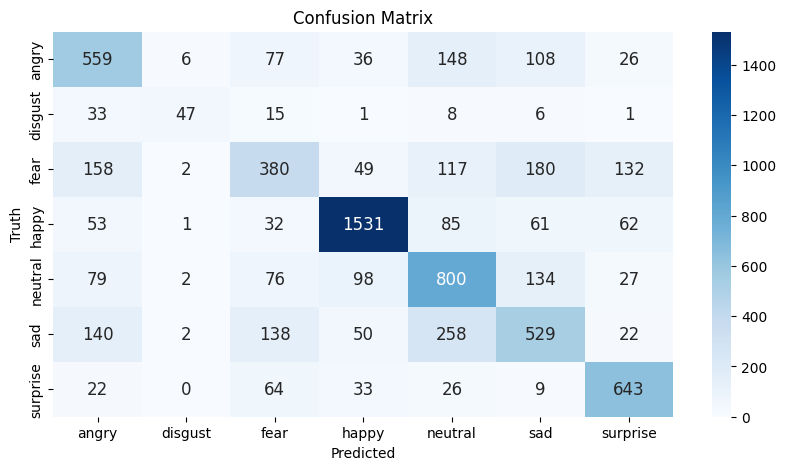

In [19]:
plot_confusion_matrix(test_dataset_no_shuffle, predicted_labels, class_names)

## Result display

Preparing a function to plot images with their associated ground truth labels and predicted labels.

In [20]:
def display_predictions(dataset, model, class_names):
  """
  Display predictions made by a model on a dataset along with ground truth labels.

  Args:
      dataset: TensorFlow Dataset object containing image and label pairs.
      model: Trained TensorFlow model for making predictions.
      class_names: List of class names corresponding to the label indices.

  Returns:
      None
  """
  num_rows = 4
  num_cols = 5
  plt.figure(figsize=(10,9))
  idx_counter = 0
  pred_idxs = []
  truth_idxs = []

  # Iterate through taken batches.
  for image_batch, labels_batch in dataset.take(1):
    # Predictions for the current batch.
    predictions = model.predict(image_batch)

    # Loop over images in the current batch.
    for idx, (prediction, truth) in enumerate(zip(predictions, labels_batch)):
      if idx_counter >= num_rows*num_cols:
        # Break from the loops if the maximum number of images have been plotted
        break
      pred_idx = np.argmax(prediction)
      truth_idx = truth.numpy()

      pred_idxs.append(pred_idx)
      truth_idxs.append(truth_idx)

      # Set title color based on prediction correctness
      title_color = 'g' if pred_idx == truth_idx else 'r'

      idx_counter += 1

      plt.subplot(num_rows, num_cols, idx_counter)
      title = f'true: {class_names[truth_idx]} \n predicted: {class_names[pred_idx]}'

      title_obj = plt.title(title)
      plt.title(title, color=title_color, fontsize=10)
      plt.axis("off")
      plt.imshow(image_batch[idx].numpy().astype("uint8"));

  # Calculate and print accuracy for the considered batches
  pred_idxs = np.array(pred_idxs)
  truth_idxs = np.array(truth_idxs)
  test_accuracy = len(pred_idxs[pred_idxs == truth_idxs]) / len(pred_idxs) * 100
  print('')
  print(f'Accuracy for displayed images: {test_accuracy:.2f}%')
  print('')
  return

Display of images and predictions as well as accuracy for displayed images.

1/1 [==============================] - 1s 524ms/step

Accuracy for displayed images: 60.00%



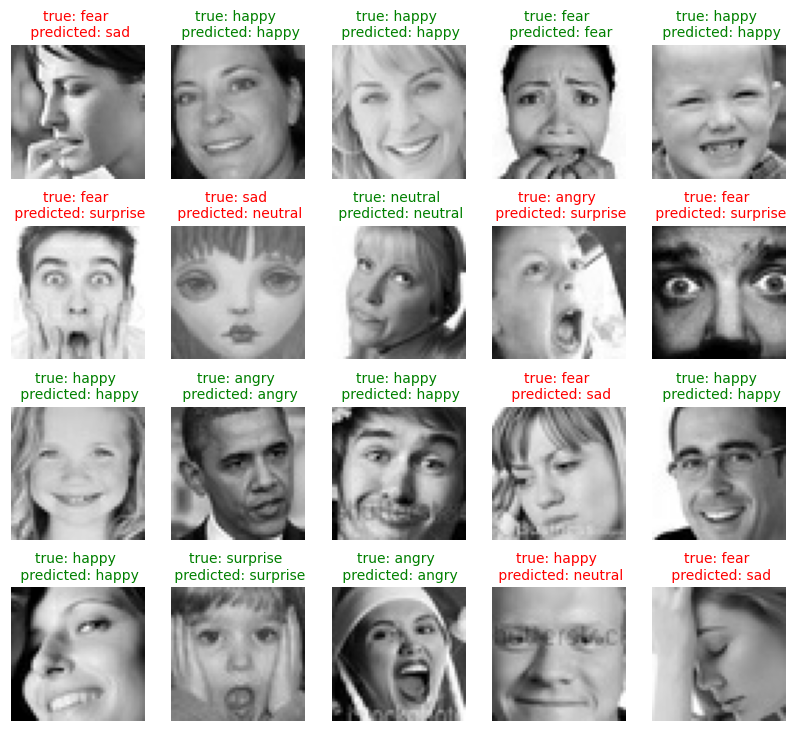

In [ ]:
display_predictions(test_dataset, best_model, class_names)

Prepare a function to plot images with their associated ground truth labels and n first predicted labels.

In [21]:
def display_n_first_predictions(dataset, model, class_names, number_of_results=1):
  """
  Display predictions made by a model on a dataset along with ground truth labels.

  Args:
      dataset: TensorFlow Dataset object containing image and label pairs.
      model: Trained TensorFlow model for making predictions.
      class_names: List of class names corresponding to the label indices.
      number_of_results: Number of top predictions to display per image.

  Returns:
      None
  """
  num_rows = 4
  num_cols = 5
  plt.figure(figsize=(10, 9 if number_of_results == 1 else 7 + number_of_results + 0.3 * number_of_results))
  idx_counter = 0
  pred_idxs = []
  truth_idxs = []

  # Iterate through objects in the batche
  for image_batch, labels_batch in dataset.take(1):

    # Predictions for the current batch.
    predictions = model.predict(image_batch)

    # Loop over all the images in the current batch.
    for idx, (prediction, truth) in enumerate(zip(predictions, labels_batch)):

      if idx_counter >= num_rows*num_cols:
        # Break from the loops if the maximum number of images have been plotted
        break

      # Most likely prediction
      pred_idx = np.argmax(prediction)
      truth_idx = truth.numpy()

      pred_idxs.append(pred_idx)
      truth_idxs.append(truth_idx)

      # Sort predictions and probabilities
      sorted_indices = np.argsort(prediction)[::-1][:number_of_results]
      sorted_labels = [class_names[i] for i in sorted_indices]
      sorted_probs = [prediction[i] for i in sorted_indices]

      # All predictions
      all_pred = predictions[idx]
      for i in range(len(all_pred)):
        label_and_prob = sorted(list(zip(class_names, all_pred)), key=lambda x: x[1], reverse=True)

      # Set title color based on prediction correctness
      title_color = 'g' if pred_idx == truth_idx else 'r'

      idx_counter += 1

      # Plot the image with the title showing predicted labels and probabilities
      plt.subplot(num_rows, num_cols, idx_counter)
      title = f'true: {class_names[truth_idx]}'
      for pred, prob in zip(sorted_labels, sorted_probs):
        title += f"\n{pred}: {prob:.2f}%"
      plt.title(title, color=title_color, fontsize=10)
      plt.axis('off')
      plt.imshow(image_batch[idx].numpy().astype('uint8'))

  pred_idxs = np.array(pred_idxs)
  truth_idxs = np.array(truth_idxs)
  test_accuracy = len(pred_idxs[pred_idxs == truth_idxs]) / len(pred_idxs) * 100
  print('')
  print(f'Accuracy for displayed images: {test_accuracy:.2f}%')
  print('')
  return

Display of images and n first predictions as well as accuracy for selected batches of the test set.

1/1 [==============================] - 1s 513ms/step

Accuracy for displayed images: 65.00%



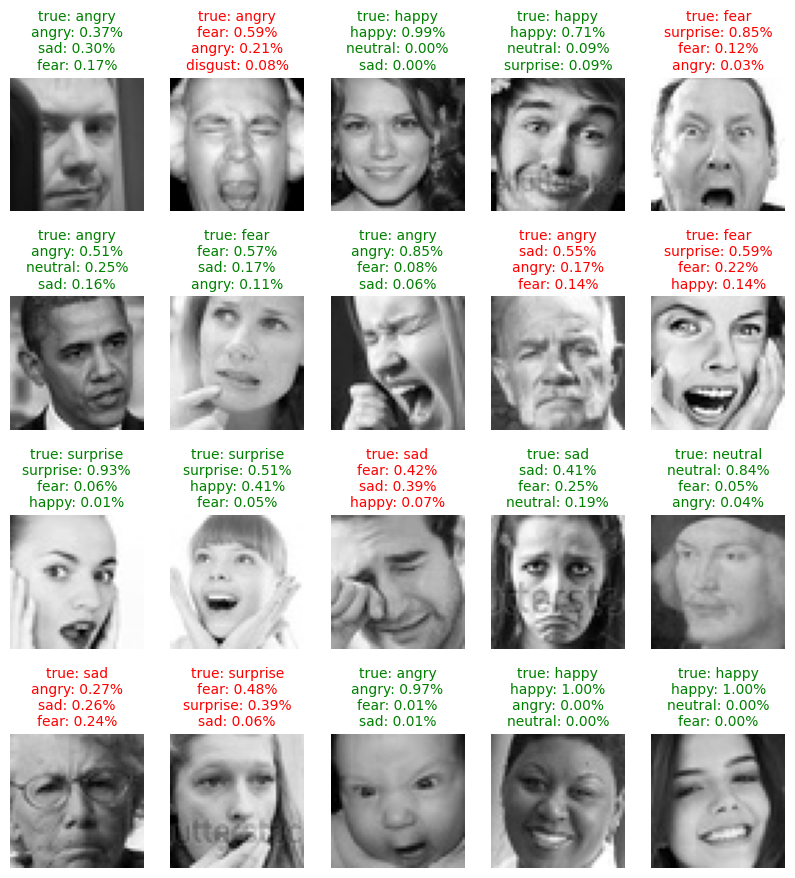

In [ ]:
display_n_first_predictions(test_dataset, best_model, class_names, 3)

## Further improvements to the model

- **Troubleshooting data quality issues**

The dataset is `not balanced`, which can affect model performance. You may consider the technique of `oversampling`, `data augmentation` or using `class weights` during model training to mitigate the imbalance.
- **Hyperparameter Tuning**

You can experiment with various hyperparameters, such as the `activation function`, `dropout rate`, `learning rate`, `number of filters` in convolutional layers, and the depth (`number of layers`) of the neural network.

- **Model Architecture**

Consider changing the `number of filters` in convolutional layers or adjusting the `number of layers` in a network.

- **Optimization Algorithm**

Experiment with different optimization algorithms such as `RMSprop`, or `SGD`.

# Transfer learning and fine-tuning

### Load the VGG-16 Convolutional Base (without fully connected leyers)

In [ ]:
# Specify the model input shape.
input_shape = (DatasetConfig.FINE_TUNE_IMG_HEIGHT, DatasetConfig.FINE_TUNE_IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = VGG16(input_shape=input_shape,
                        include_top=False, # We exclude the fully connected layers and we will supply our own top.
                        weights='imagenet', # With weights that were learned by training the model on the ImageNet dataset
                        )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                       

### Freeze the Initial Layers in the Convolutional Base

In [ ]:
# Set all layers in the convolutional base to Trainable (below we will freeze the initial layers).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
  print(f"Freezing layer: {model_layer}")
  model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers.")
print("\n")

print(vgg16_conv_base.summary())

Freezing layer: <keras.src.engine.input_layer.InputLayer object at 0x7f167c48cee0>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5a2350>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5a26e0>
Freezing layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f167e5a3970>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5a22c0>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5b69e0>
Freezing layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f167e5b7250>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5b6950>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e5b7790>
Freezing layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f167e57b370>
Freezing layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f167e5b4eb0>
Freezing layer: 

### Add the Classifier to complete the model

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               321139

## Model training

Create resized image data sets.

In [22]:
fine_tune_train_dataset, fine_tune_valid_dataset = image_dataset_from_directory(directory=DatasetConfig.TRAIN_DATA_PATH,
                                                            batch_size=TrainingConfig.BATCH_SIZE,
                                                            shuffle=True,
                                                            seed=SEED_VALUE,
                                                            label_mode='int',
                                                            image_size=(DatasetConfig.FINE_TUNE_IMG_HEIGHT, DatasetConfig.FINE_TUNE_IMG_WIDTH),
                                                            validation_split=0.3,
                                                            subset = 'both'
                                                          )

fine_tune_test_dataset = image_dataset_from_directory(directory=DatasetConfig.TEST_DATA_PATH,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.FINE_TUNE_IMG_HEIGHT, DatasetConfig.FINE_TUNE_IMG_WIDTH)
                                            )

Found 28821 files belonging to 7 classes.
Using 20175 files for training.
Using 8646 files for validation.
Found 7066 files belonging to 7 classes.


Model compilation

In [ ]:
model_vgg16_finetune.compile(optimizer=Adam(learning_rate=TrainingConfig.FINE_TUNE_LEARNING_RATE),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy']
                             )

Start of model training

In [ ]:
results = model_vgg16_finetune.fit(fine_tune_train_dataset,
                                   batch_size=TrainingConfig.BATCH_SIZE,
                                   epochs=TrainingConfig.FINE_TUNE_EPOCHS,
                                   verbose=1,
                                   validation_data=fine_tune_valid_dataset
                                   )

Epoch 1/10
631/631 [==============================] - 152s 223ms/step - loss: 1.7469 - accuracy: 0.3346 - val_loss: 1.4343 - val_accuracy: 0.4495
Epoch 2/10
631/631 [==============================] - 138s 218ms/step - loss: 1.4249 - accuracy: 0.4588 - val_loss: 1.3061 - val_accuracy: 0.5075
Epoch 3/10
631/631 [==============================] - 131s 207ms/step - loss: 1.2577 - accuracy: 0.5256 - val_loss: 1.2147 - val_accuracy: 0.5445
Epoch 4/10
631/631 [==============================] - 131s 208ms/step - loss: 1.1059 - accuracy: 0.5922 - val_loss: 1.1844 - val_accuracy: 0.5584
Epoch 5/10
631/631 [==============================] - 131s 208ms/step - loss: 0.9516 - accuracy: 0.6560 - val_loss: 1.2631 - val_accuracy: 0.5599
Epoch 6/10
631/631 [==============================] - 131s 208ms/step - loss: 0.7843 - accuracy: 0.7161 - val_loss: 1.3122 - val_accuracy: 0.5766
Epoch 7/10
631/631 [==============================] - 138s 218ms/step - loss: 0.6175 - accuracy: 0.7801 - val_loss: 1.3761 -

Save the model

In [ ]:
save_model(model_vgg16_finetune, '/content/drive/MyDrive/cnn/my_fine_tune_model')

## Plot Loss and Accuracy

Retrieve training results (loss and accuracy for train and validation set) and displaying them on a chart.

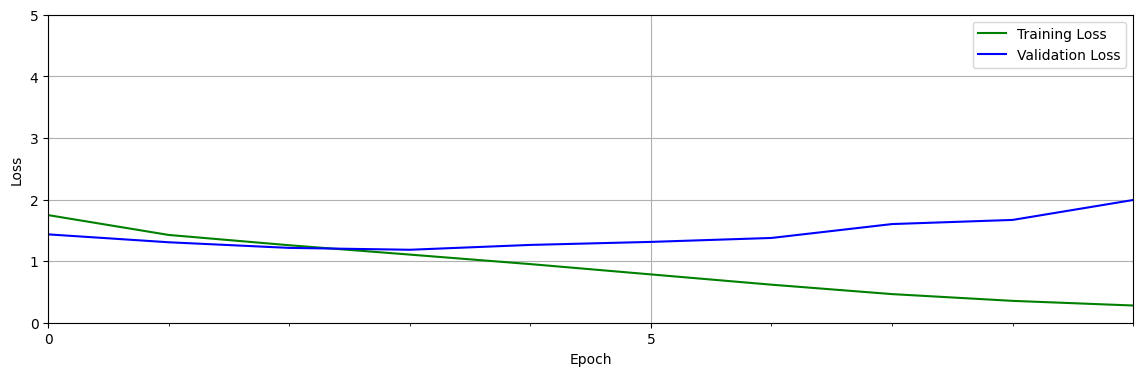

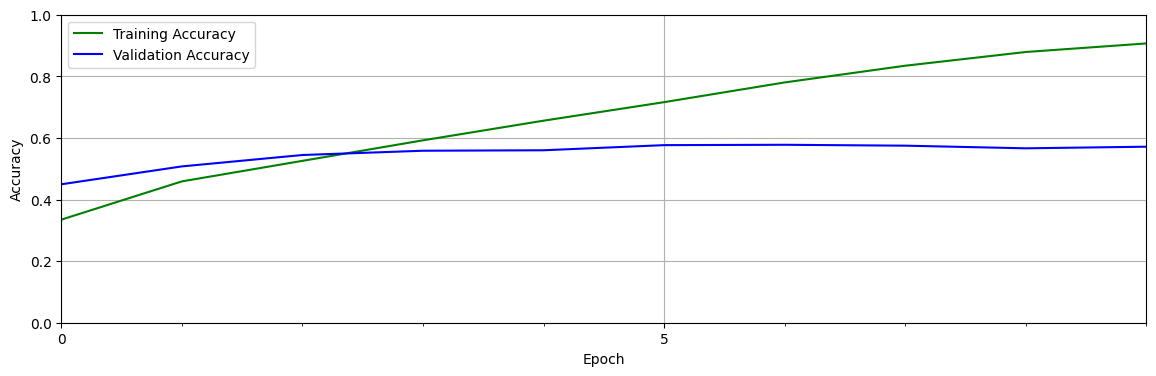

In [ ]:
# Retrieve training results.
train_loss = results.history["loss"]
train_acc  = results.history["accuracy"]
valid_loss = results.history["val_loss"]
valid_acc  = results.history["val_accuracy"]

plot_metric([train_loss, valid_loss],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"],
            epochs=TrainingConfig.FINE_TUNE_EPOCHS);

print('\n')
plot_metric([train_acc, valid_acc],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"],
            epochs=TrainingConfig.FINE_TUNE_EPOCHS)

## Model evaluation
Verification of model performance on test set

Load the model

In [23]:
fine_tune_model = load_model('/content/drive/MyDrive/cnn/my_fine_tune_model')

Loss and Accuracy

In [24]:
test_loss, test_accuracy = fine_tune_model.evaluate(fine_tune_test_dataset)
print(f'Test loss: {test_loss:.3f}')
print(f'Test accuracy: {test_accuracy*100:.3f}%')

221/221 [==============================] - 38s 144ms/step - loss: 1.9556 - accuracy: 0.5737
Test loss: 1.956
Test accuracy: 57.373%


Precision, Recall, F1

To calculate additional metrics (`Precision`, `Recall`, `F1`) we will use the function `classification_report` from the module `sklearn.metrics`.

Before that, we will re-create the test set, deactivating the element shuffling operation (by setting `shuffle=False`), so that when retrieving data from the test set, we will get the same order of elements every time.

In [25]:
fine_tune_test_dataset_no_shuffle = image_dataset_from_directory(directory=DatasetConfig.TEST_DATA_PATH,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.FINE_TUNE_IMG_HEIGHT, DatasetConfig.FINE_TUNE_IMG_WIDTH))

Found 7066 files belonging to 7 classes.


Make predictions and determine predicted labels

In [27]:
predictions = fine_tune_model.predict(fine_tune_test_dataset_no_shuffle)
predicted_labels = np.argmax(predictions, axis=1)

221/221 [==============================] - 27s 120ms/step


Determine true labels

In [ ]:
# Flatten true labels from the test dataset
label_values = [label.numpy() for _, label in fine_tune_test_dataset_no_shuffle.unbatch()]
true_labels = np.array(label_values)

Display of metrics

In [28]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.56      0.37      0.45       960
           1       0.69      0.33      0.45       111
           2       0.38      0.43      0.41      1018
           3       0.68      0.88      0.77      1825
           4       0.56      0.48      0.52      1216
           5       0.44      0.46      0.45      1139
           6       0.78      0.63      0.70       797

    accuracy                           0.57      7066
   macro avg       0.58      0.51      0.53      7066
weighted avg       0.57      0.57      0.57      7066



We can see that the model based on transfer learning performs slightly worse than the model built from scratch.

## Confusion matrix for the model

Displaying Confusion Matrix

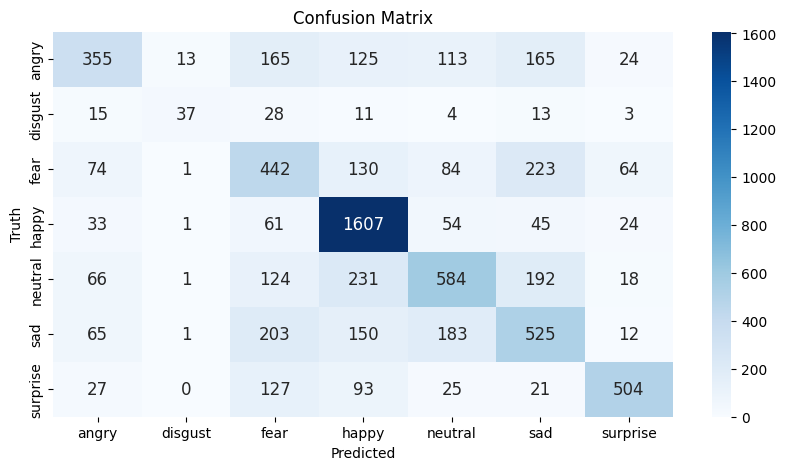

In [29]:
plot_confusion_matrix(fine_tune_test_dataset_no_shuffle, predicted_labels, class_names)

## Result display

Display of images and predictions as well as accuracy for selected batches of the Test dataset.

1/1 [==============================] - 0s 160ms/step

Accuracy for displayed images: 65.00%



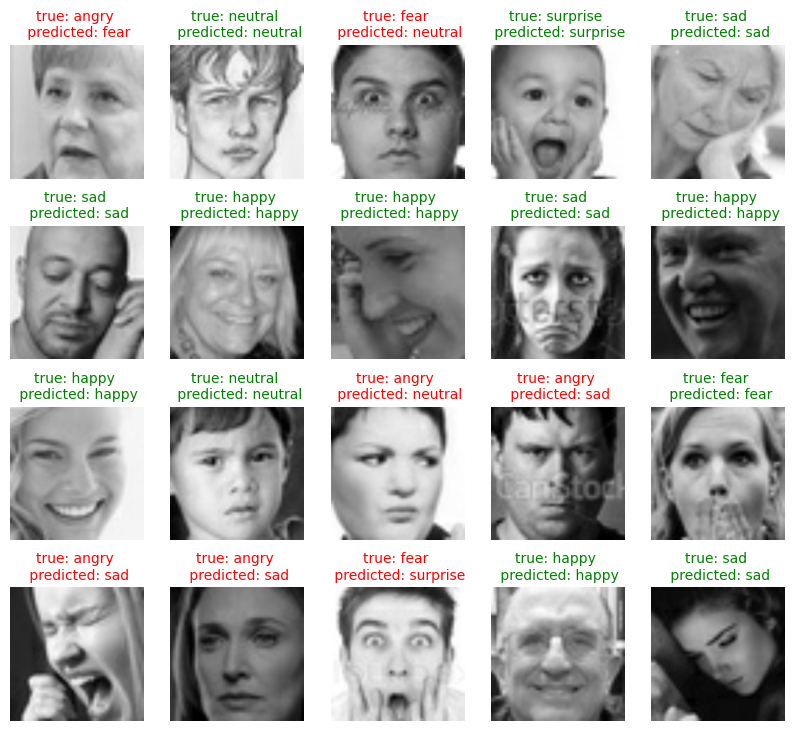

In [30]:
display_predictions(fine_tune_test_dataset, fine_tune_model, class_names)

Display of images and n first predictions as well as accuracy for selected batches of the Test dataset.

1/1 [==============================] - 0s 36ms/step

Accuracy for displayed images: 60.00%



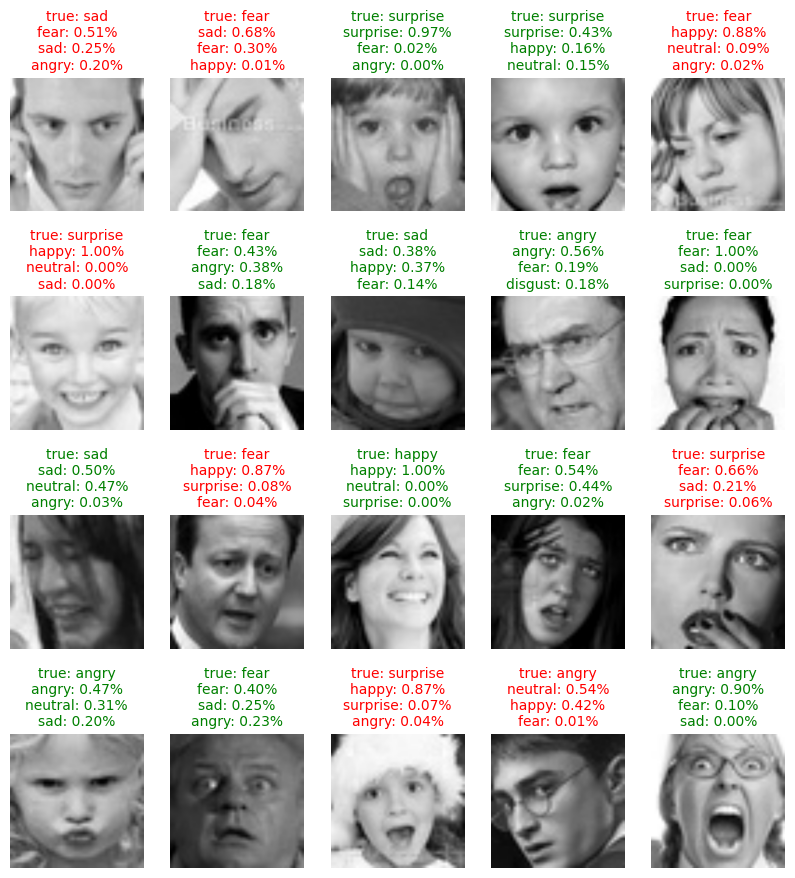

In [35]:
display_n_first_predictions(fine_tune_test_dataset, fine_tune_model, class_names, 3)

## Further improvements to the model (transfer learning)

In addition to the suggestions for improvements proposed for a model built from scratch, it is worthwhile to additionally consider using different pre-trained models or determine another number of layers of the pre-trained model for further training.